## data preparation

In [8]:
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
POINTS_NUM = 10
CLASSES_NUM = 2

import numpy as np
points = np.load(f'/host/dissertation/proccessed_data/points_{POINTS_NUM}.npy')
q = np.load('/host/dissertation/proccessed_data/q.npy')
q[q == -1] = 0
q_labels = tf.one_hot(q, CLASSES_NUM)

2023-11-18 18:00:47.024734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 18:00:47.024890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 18:00:47.024977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
import sys
ABS_ROOT_DIR_PATH = '/host/dissertation/'
if ABS_ROOT_DIR_PATH not in sys.path:
    sys.path.append(ABS_ROOT_DIR_PATH)

## manual testing

In [4]:
import cvnn.layers as complex_layers

model = tf.keras.models.Sequential()
model.add(complex_layers.ComplexInput(input_shape=(POINTS_NUM,)))
model.add(complex_layers.ComplexDense(units=64, activation='pol_sigmoid'))
model.add(complex_layers.ComplexDense(units=64, activation='pol_sigmoid'))
model.add(complex_layers.ComplexDense(units=64, activation='pol_sigmoid'))
model.add(complex_layers.ComplexDense(units=CLASSES_NUM, activation='softmax_real_with_abs'))
model.compile(optimizer=tf.keras.optimizers.SGD(clipnorm=1.), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_dense (ComplexDens  (None, 64)                1408      
 e)                                                              
                                                                 
 complex_dense_1 (ComplexDe  (None, 64)                8320      
 nse)                                                            
                                                                 
 complex_dense_2 (ComplexDe  (None, 64)                8320      
 nse)                                                            
                                                                 
 complex_dense_3 (ComplexDe  (None, 2)                 260       
 nse)                                                            
                                                                 
Total params: 18308 (71.52 KB)
Trainable params: 18308 (

In [5]:
from common.model import FreeMemory
history = model.fit(points, q_labels, epochs=350, validation_split=0.2, verbose=0, callbacks=[FreeMemory(25)])

2023-11-18 18:01:04.207141: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcf884da5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-18 18:01:04.207160: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-11-18 18:01:04.299073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-18 18:01:04.331306: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


epoch 0 ended, info: {'loss': 0.6997293829917908, 'accuracy': 0.5837796330451965, 'val_loss': 0.6881129145622253, 'val_accuracy': 0.6028151512145996}
epoch 25 ended, info: {'loss': 0.5362622141838074, 'accuracy': 0.8298393487930298, 'val_loss': 0.5095180869102478, 'val_accuracy': 0.8733170032501221}
epoch 50 ended, info: {'loss': 0.4751163721084595, 'accuracy': 0.8974751234054565, 'val_loss': 0.5565346479415894, 'val_accuracy': 0.8108935356140137}
epoch 75 ended, info: {'loss': 0.445139616727829, 'accuracy': 0.9274674654006958, 'val_loss': 0.45470985770225525, 'val_accuracy': 0.9088127017021179}
epoch 100 ended, info: {'loss': 0.4303557276725769, 'accuracy': 0.9387910962104797, 'val_loss': 0.4184838533401489, 'val_accuracy': 0.9626682996749878}
epoch 125 ended, info: {'loss': 0.4195987284183502, 'accuracy': 0.9467482566833496, 'val_loss': 0.43132710456848145, 'val_accuracy': 0.9277845621109009}
epoch 150 ended, info: {'loss': 0.41497674584388733, 'accuracy': 0.955317497253418, 'val_los

99th percentile of train accuracy:       9.6863e-01
99th percentile of validation accuracy:  9.7889e-01


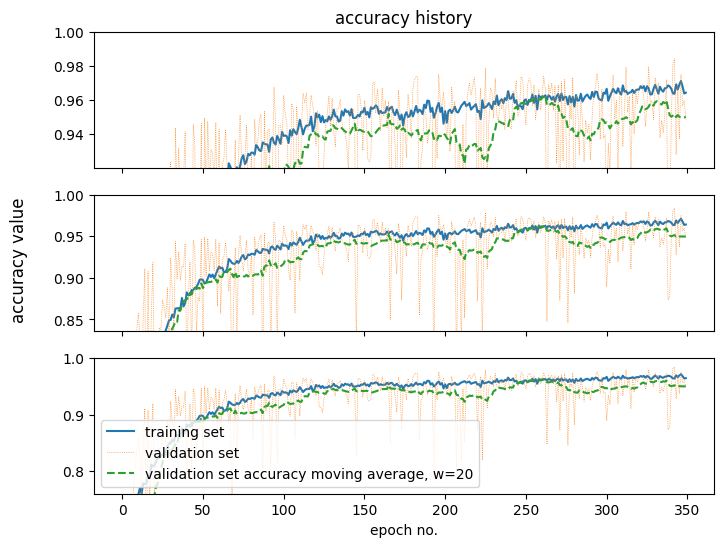

In [6]:
from common.plot import plot_metric_history_zoomed
plot_metric_history_zoomed(history, metric='accuracy', mode='max', moving_average_window=(20,), threshold_multiplier=0.95)

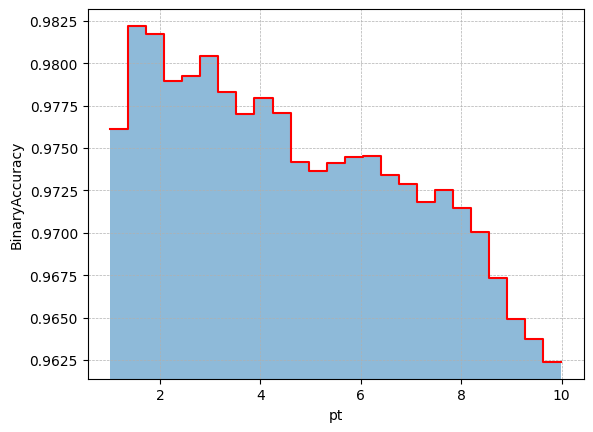

In [20]:
from common.utils import validation_set, train_set
from common.plot import plot_steps_by_parameter

pt = np.load('/host/dissertation/proccessed_data/pt.npy')
plot_steps_by_parameter(x_data=points, y_data=q_labels, parameter=pt, 
                        metric_func=tf.keras.metrics.BinaryAccuracy(),
                        metric_label='BinaryAccuracy', parameter_label='pt',
                        filter=train_set)

## space search

In [6]:
from common.search import ConfigsTester

configs_tester = ConfigsTester(spacepoints_number_space = [10,],
                               hiddenlayers_number_space = [3,2,],
                               hiddenlayers_neurons_number_space = [128,],
                               hiddenlayers_activation_func_space = ['pol_sigmoid','pol_tanh','cart_relu',],
                               outputlayer_activation_func_space = ['sigmoid_real', 'softmax_real_with_abs', 'softmax_real_with_polar', 'softmax_real_with_avg', 'softmax_real_with_mult', 'softmax_of_softmax_real_with_avg', 'softmax_of_softmax_real_with_mult' ],
                               metric = 'accuracy')


In [7]:
import cvnn.layers as complex_layers
from common.model import FreeMemory

configs_tester.test_configs(y_data=q_labels,
                            optimizer_factory=lambda: tf.keras.optimizers.SGD(clipnorm=1.), 
                            loss='binary_crossentropy', 
                            epochs=250, 
                            scenario='q outputlayer_activation_func_space',
                            callbacks=[FreeMemory()])

START (6, 2, 64, 'pol_sigmoid', 'sigmoid_real')
      model compiled
      training...


2023-11-07 14:12:03.297400: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f61f00be7f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-07 14:12:03.297419: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-11-07 14:12:03.430063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-07 14:12:03.463280: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      model trained
      hp_file appended
      history saved
      weights saved
DONE  (6, 2, 64, 'pol_sigmoid', 'sigmoid_real')
START (6, 2, 64, 'pol_sigmoid', 'softmax_real_with_abs')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (6, 2, 64, 'pol_sigmoid', 'softmax_real_with_abs')
START (6, 2, 64, 'pol_sigmoid', 'softmax_real_with_polar')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (6, 2, 64, 'pol_sigmoid', 'softmax_real_with_polar')
START (6, 2, 64, 'pol_sigmoid', 'softmax_real_with_avg')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (6, 2, 64, 'pol_sigmoid', 'softmax_real_with_avg')
START (6, 2, 64, 'pol_sigmoid', 'softmax_real_with_mult')
      model compiled
      training...
      model trained
      hp_file appended
      history sav